# 🧠 Concept Drift Detection Using Fisher’s Exact Test (FET) – Alibi Detect

---

## 🔍 What Is Concept Drift?

**Concept drift** occurs when the statistical relationship between inputs (`X`) and outputs (`y`) changes over time:

> **P(y | x)** changes as the data evolves.

This is different from:
- **Data drift** → change in `P(x)`
- **Label drift** → change in `P(y)`

Concept drift can degrade a model’s performance even if the input data distribution stays the same.

---

## 📊 What Is Fisher’s Exact Test (FET)?

Fisher’s Exact Test is a **non-parametric** statistical test that determines if there's a significant change in the proportion of two binary outcomes — in this case, **correct vs. incorrect predictions**.

### In model monitoring, FET is used to answer:
> *Has my model's prediction performance changed in a statistically significant way?*

---

## 🔧 How Alibi Detect Uses FET for Concept Drift

Alibi Detect implements FET for **supervised drift detection** (i.e., when true labels are available). It works as follows:

### 🪜 Step-by-Step:

1. **Collect Reference and Test Data**
   - `X_ref`, `y_ref`: historical model inputs and true labels
   - `X_test`, `y_test`: recent production inputs and labels

2. **Run the Model on Both Datasets**
   - `ŷ_ref = model(X_ref)`
   - `ŷ_test = model(X_test)`

3. **Convert Predictions to Binary Accuracy Arrays**
   - 1 = prediction was correct, 0 = incorrect
   - e.g., `correct_ref = (ŷ_ref == y_ref).astype(int)`

4. **Use FET to Compare Performance**
   - Build a 2x2 contingency table:
     |               | Correct | Incorrect |
     |---------------|---------|-----------|
     | **Reference** |    a    |     b     |
     | **Test**      |    c    |     d     |
   - FET checks if the proportions in the table have changed beyond random chance.

5. **Interpret Results**
   - **`p-value < 0.05`** → statistically significant drop in accuracy → **potential concept drift**
   - Output includes `is_drift`, `p_val`, and metadata

---

## 🧠 Where Is `X` in All This?

Good question!

- FET **does not directly take `X`** as input.
- However, the model **uses `X` to make predictions**.
- So, **`X` is involved indirectly** — if `P(y|x)` changes, the model will make more mistakes.

This makes FET a valid form of **indirect concept drift detection**, because it picks up changes in how well the model’s learned `P(y|x)` aligns with the current reality.

---

## 🔗 Relevant Links

- 📘 Alibi Detect Docs – Fisher’s Exact Test (FET):  
  [https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/fetdrift.html](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/fetdrift.html)

- 🐧 Supervised Drift Example (Penguins Dataset):  
  [https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_supervised_penguins.html](https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_supervised_penguins.html)

---

## ✅ Summary

| Feature                     | Fisher’s Exact Test (FET)                          |
|----------------------------|----------------------------------------------------|
| Uses input `x`?            | ❌ (indirectly via model)                          |
| Requires true labels `y`?  | ✅                                                 |
| Measures change in `P(y \| x)` | ✅ (indirectly)                              |
| Works with small datasets  | ✅                                                 |
| Use case                   | Concept drift via accuracy change                 |

---


In [12]:
# Import necessary libraries
from alibi_detect.cd import FETDrift
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the inference data
file_2021_01 = '/home/nuno_paiva_nos_pt/ml-ai-experiments/mlops-zoomcamp-experiment-tracking/data/inference/inference_2021-01.csv'
file_2021_03 = '/home/nuno_paiva_nos_pt/ml-ai-experiments/mlops-zoomcamp-experiment-tracking/data/inference/inference_2021-03.csv'
df_2021_01 = pd.read_csv(file_2021_01)
df_2021_03 = pd.read_csv(file_2021_03)

# Extract the prediction correctness as binary arrays
correct_2021_01 = (df_2021_01['y_true'] == df_2021_01['y_pred']).astype(int).values
correct_2021_03 = (df_2021_03['y_true'] == df_2021_03['y_pred']).astype(int).values

# Initialize FETDrift detector
fet_drift = FETDrift(x_ref=correct_2021_01)

# Perform drift detection
result = fet_drift.predict(correct_2021_03, drift_type="batch")

# Extract relevant information
is_drift = result['data']['is_drift']
p_val = result['data']['p_val'][0]  # Assuming a single p-value

# Output the results
print(f"Drift detected: {bool(is_drift)}")
print(f"P-value: {p_val}")

Drift detected: True
P-value: 0.009174064270544657


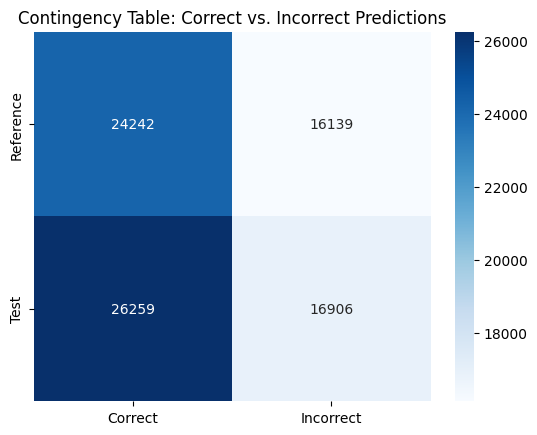

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
contingency_table = {
    "Correct": [sum(correct_2021_01), sum(correct_2021_03)],
    "Incorrect": [len(correct_2021_01) - sum(correct_2021_01), len(correct_2021_03) - sum(correct_2021_03)],
}
contingency_df = pd.DataFrame(contingency_table, index=["Reference", "Test"])

# Plot the heatmap
sns.heatmap(contingency_df, annot=True, fmt="d", cmap="Blues")
plt.title("Contingency Table: Correct vs. Incorrect Predictions")
plt.show()